In [1]:
# Finding the charge density of one grid cell in my cloud simulations, and interpolating to increase the resolution
# This code should be run after charge_density.py finds which extract is the best to use

import numpy as np 
from netCDF4 import Dataset 
from scipy.special import gamma
from astropy.io import ascii
from scipy import interpolate
from scipy.integrate import trapz
import os
import matplotlib.pyplot as plt
%matplotlib notebook

#n = int(input('Input extract # with max charge separation => ')) # read in the best extract
n = 1 # Change n to the number of the extract with the maximum charge separation

basefolder = '/d1/cklare2017/simulations/lightning-sims/jupiter-9/jet/2xsolar/clouds/' # where my simulations are
newpath = basefolder + 'charge-density' # where I will save the outputs
# make the newpath if it doesn't exist yet
if not os.path.exists(newpath):
    os.makedirs(newpath)

epic_outputs = Dataset(basefolder + 'extract%d.nc'%(n+100)) # read in the file
#print(epic_outputs.variables) # to see units of the variables

# get the data we want from EPIC outputs
temp = epic_outputs.variables['t'][:] # extract temperature (time, pressure, latitude, longitude), in Kelvins
temp = temp[0, :, :, :] # subset the data so the time dimension is gone-not relevant

# import latitude and longitude
lat = epic_outputs.variables['lat_u'][:] # in degrees
lon = epic_outputs.variables['lon_u'][:] # in degrees

# Find cloud water mixing ratio (q_c)
w_ice = epic_outputs.variables['H_2O_solid'][:] # mass mixing ratio of cloud ice H_2O in kg/kg
w_vapor = epic_outputs.variables['H_2O_vapor'][:] # mass mixing ratio of vapor H_2O (kg/kg)
w_liquid = epic_outputs.variables['H_2O_liquid'][:] # mass mixing ratio of cloud liquid H_2O (kg/kg)
w_rain = epic_outputs.variables['H_2O_rain'][:] # mass mixing ratio of rain (kg/kg)
w_snow = epic_outputs.variables['H_2O_snow'][:] # mass mixing ratio of snow (kg/kg)

# subset the data (get rid of the time dimension)
w_ice = w_ice[0, :, :, :] # water ice mixing ratio, kg/kg
w_vapor = w_vapor[0, :, :, :] # water vapor mixing ratio, kg/kg
w_liquid = w_liquid[0, :, :, :] # water liquid cloud mixing ratio, kg/kg
w_rain = w_rain[0, :, :, :] # water rain mixing ratio, kg/kg
w_snow = w_snow[0, :, :, :] # snow mixing ratio, kg/kg

P_dry = epic_outputs.variables['pdry'][:] # Pressure of the dry atmosphere, in Pa
P_dry = P_dry[0, :, :, :] ## subset the data

# altitude
z = epic_outputs.variables['z'][:] # altitude (related to pressure by the scale height) (in m)
z = z[0,:,0,0]

In [2]:
#### Part 1 - Finding the charge separation using the Gardiner/Ziegler Scheme ####

# First, find dimensions of simulation
pressure_dim = len(temp[:,0,0]) # number of pressure gridpoints
lat_dim = len(temp[0,:,0]) # number of latitude gridpoints
lon_dim = len(temp[0,0,:]) # number of longitude gridpoints

# Scaled Temperature
Tr = -21.0 # reversal temperature degrees celsius
temp_celsius = temp - 273.15 # convert temp from K to degrees celsius
tau = np.zeros(np.shape(temp)) # initialize the scaled temperature array
f_tau = np.zeros(np.shape(temp)) # f(tau)

# find the scaled temperature at each gridpoint
for i in range(lat_dim):
    for j in range(lon_dim):
        for k in range(pressure_dim):
            tau[k,i,j] = (-21/Tr)*(temp_celsius[k,i,j]-273.16) # scaled temperature, in celsius
            f_tau[k,i,j] = -1.7*10**(-5)*tau[k,i,j]**3-0.003*tau[k,i,j]**2-0.05*tau[k,i,j]+0.13

# finding delta L
CWC_crit = np.ones(np.shape(temp))*0.1 # critical cloud water content, in g/m**3 
# Calculate CWC in g/m**3 - density
Ratmo = 3637 # gas constant for Jupiter's atmosphere, in J*kg/m*K

rho_dry = P_dry/(Ratmo*temp) # density of the dry atmosphere (kg/m**3)
CWC_ice = w_ice*rho_dry*1000 # ice water content in g/m**3
CWC_vapor = w_vapor*rho_dry*1000 # vapor water content in g/m**3
CWC_liquid = w_liquid*rho_dry*1000 # liquid cloud water content in g/m**3
CWC_rain = w_rain*rho_dry*1000 # rain water content in g/m**3
CWC_snow = w_snow*rho_dry*1000 # snow water content in g/m**3
CWC_all = CWC_ice + CWC_vapor + CWC_liquid + CWC_rain + CWC_snow # CWC if we include everything
CWC_only_liq = CWC_rain + CWC_liquid # CWC if we include just water
CWC_icesnow = CWC_ice + CWC_snow

CWC_final = CWC_icesnow # change this to whichever one we want to test (in g/m**3)

# finding n_ice and n_snow an easy way
m_water = 18*1.674**10**-24 # mass of a water molecule, in grams
n_ice_ez = CWC_ice/m_water # number density of ice (m**-3)
n_snow_ez = CWC_snow/m_water # number density of snow

# Now, to find delta Ls - different delta L for each species
dL_ice = np.zeros(np.shape(temp))
#dL_vapor = np.zeros(np.shape(temp))
#dL_liquid = np.zeros(np.shape(temp))
#dL_rain = np.zeros(np.shape(temp))
dL_snow = np.zeros(np.shape(temp))
for i in range(lat_dim):
    for j in range(lon_dim):
        for k in range(pressure_dim):
            if temp[k,i,j] > Tr:
                dL_ice[k, i, j] = CWC_final[k,i,j]-CWC_crit[k,i,j] # find dL for ice, in g/m**3
                dL_snow[k, i, j] = CWC_final[k,i,j]-CWC_crit[k,i,j] # find dL for snow, in g/m**3
            elif temp[k,i,j] <= Tr and CWC_final[k,i,j] >= 10**(-6):
                dL_ice[k, i, j] = CWC_final[k,i,j] # find dL for ice, in g/m**3
                dL_snow[k, i, j] = CWC_final[k,i,j] # find dL for snow, in g/m**3
    
# Diameter of ice particles 
# This is calculated using the methods described in Dr. Palotai's 2008 paper
# first, define the power law constants
alpha = 7.06165*10**(-3) # alpha constant for water ice
beta = 2.0 # for water ice
c = 5.38*10**7 # for water ice
d = 0.75 # for water ice
N_ice = np.zeros(np.shape(temp)) # Number density of ice
M_ice = np.zeros(np.shape(temp)) # mass of the ice
D_ice = np.zeros(np.shape(temp)) # diameter of the ice

for i in range (lat_dim):
    for j in range(lon_dim):
        for k in range(pressure_dim):
            N_ice[k,i,j] = c*(rho_dry[k,i,j]*w_ice[k,i,j])**d # Number density of ice, defined in the paper, in m**-3
            if N_ice[k,i,j] != 0: # avoid dividing by zero
                M_ice[k,i,j] = (rho_dry[k,i,j]*w_ice[k,i,j])/N_ice[k,i,j] # mass of ice, in kg
                D_ice[k,i,j] = (M_ice[k,i,j]/alpha)**(1/beta) # Diameter of the ice particles, in meters

# mass weighted average terminal fall speeds
# Terminal Velocity of Snow (graupel) and terminal velocity of ice
# terminal velocity of the ice particles is negligble compared to the terminal velocity of snow, so we approximate
# delta_v = vt_snow. Dr. Palotai says if Dr. Riousset has a problem with this approximation we can make it more accurate

delta_v = np.zeros(np.shape(temp)) # mass averaged terminal velocity of snow in m/s
P_0 = 100000 # reference pressure, in Pa
gamma_var = 0.47 # gamma is the same for ice and snow ice
x_snow = 50.172 
y_snow = 0.47798
rho_snow = 0.5*917 # density of snow (kg/m**3) (half of the density of ice)
T_tp = 273.16 # temperature of the triple point of water
# Find N_0_snow, the intercept parameter
N_0_snow = np.ones(np.shape(temp))
# find lambda_snow, the slope parameter (m**-1)
lambda_snow = np.zeros(np.shape(temp))
for i in range(lat_dim):
    for j in range(lon_dim):
        for k in range(pressure_dim):
            if 0.01*np.exp(-0.12*(temp[k,i,j]-T_tp)) < 1:
                N_0_snow[k,i,j] = 2*10**8*0.01*np.exp(-0.12*(temp[k,i,j]-T_tp))
            else:
                N_0_snow[k,i,j] = 2*10**8
            if w_snow[k,i,j]*rho_dry[k,i,j] == 0: # to avoid a divide by zero error
                lambda_snow[k,i,j] = 0
                delta_v[k,i,j] = 0
            else:
                lambda_snow[k,i,j] = (np.pi*rho_snow*N_0_snow[k,i,j]/(rho_dry[k,i,j]*w_snow[k,i,j]))**(1/4)
                delta_v[k,i,j] = x_snow/(lambda_snow[k,i,j]**y_snow)*gamma(y_snow+4)/6*(P_0/P_dry[k,i,j])**gamma_var # units?

# delta v is in m/s
# calculate delts v for Earth and plot with delta v for Jupiter and make sure it's 50%-200% greater than Earth

#### Now, we can find the charge separation of each species
delta_q_ice = np.zeros(np.shape(temp),dtype = float) # the charge separation
delta_q_snow = np.zeros(np.shape(temp),dtype = float) # the charge separation
for i in range (lat_dim):
    for j in range(lon_dim):
        for k in range(pressure_dim):
            delta_q_ice[k, i, j] = 7.3*D_ice[k,i,j]**4*delta_v[k,i,j]**3*dL_ice[k,i,j]*f_tau[k,i,j] # find delta q of ice
            delta_q_snow[k, i, j] = 7.3*D_ice[k,i,j]**4*delta_v[k,i,j]**3*dL_snow[k,i,j]*f_tau[k,i,j] # find delta q of snow
#delta_q = delta_q_ice + delta_q_snow # sum all the delta qs together

# question - did we establish the units of delta_q? 

# finding the number densities of everything else

# Number density of vapor - assume water vapor is an ideal gas
# PV = nRT
# N = n/V
# N = P/RT (not specific R, the R)
R = 8.3145 # J/(mol*K)
N_moles = P_dry/(R*temp) # moles/m**3
N_vapor = 6.02*10**23*N_moles # particles/m**3
#print(N_vapor)

# we already have N_ice

# N_rain and snow and liquid
# Note - N_0_snow is the same as N_0 for all  the other species except rain
N_0_rain = 8*10**6 # the intercept parameter for rain (pg 24 in Dr. Palotai's paper)
rho_liquid_water = 1000.0 # (kg/m**3) - density of cloud water and rain
lambda_rain = np.zeros(np.shape(temp))
lambda_snow = np.zeros(np.shape(temp))
lambda_liquid = np.zeros(np.shape(temp))
D_min = 200*10**-6 # minimum raindrop diameter (m)
D_max = 5*10**-3 # maximum raindrop diameter (m)
rain_diameters = np.linspace(D_min, D_max, 100)
snow_diameters = np.linspace(2*10**-3,5*10**-3) # snow diameters
liquid_diameters = np.linspace(1*10**-6,200*10**-6) # cloud water droplet diameters


N_rain = np.zeros(np.shape(temp)) # m**-3
N_snow = np.zeros(np.shape(temp))
N_liquid = np.zeros(np.shape(temp))

for i in range(lat_dim):
    for j in range(lon_dim):
        for k in range(pressure_dim):
            if w_rain[k,i,j] != 0:
                lambda_rain[k,i,j] = (np.pi*rho_liquid_water*N_0_rain/(rho_dry[k,i,j]*w_rain[k,i,j]))
                N_rain[k,i,j] = trapz(N_0_rain*np.exp(-lambda_rain[k,i,j]*rain_diameters))
            if w_snow[k,i,j] != 0:
                lambda_snow[k,i,j] = (np.pi*rho_snow*N_0_snow[k,i,j]/(rho_dry[k,i,j]*w_snow[k,i,j]))**(1/4)
                N_snow[k,i,j] = trapz(N_0_snow[k,i,j]*np.exp(-lambda_snow[k,i,j]*snow_diameters))
            if w_liquid[k,i,j] != 0:
                lambda_liquid[k,i,j] = (np.pi*rho_liquid_water*N_0_rain/(rho_dry[k,i,j]*w_liquid[k,i,j]))**(1/4)
                N_liquid[k,i,j] = trapz(N_0_rain*np.exp(-lambda_liquid[k,i,j]*liquid_diameters))



N_total = N_ice + N_snow

# assign signs to the charge separations
delta_q_snow_pm = np.zeros(np.shape(temp))
delta_q_ice_pm = np.zeros(np.shape(temp))
for i in range(lat_dim):
    for j in range(lon_dim):
        for k in range(pressure_dim):
            if CWC_snow[k,i,j] > CWC_crit[k,i,j] and temp_celsius[k,i,j] > Tr:
                delta_q_snow_pm[k,i,j] = abs(delta_q_snow[k,i,j])
            else:
                delta_q_snow_pm[k,i,j] = -1*abs(delta_q_snow[k,i,j])
            if CWC_ice[k,i,j] > CWC_crit[k,i,j] and temp_celsius[k,i,j] > Tr:
                delta_q_ice_pm[k,i,j] = abs(delta_q_ice[k,i,j])
            else:
                delta_q_ice_pm[k,i,j] = -1*abs(delta_q_ice[k,i,j])
                
# find the total charge density
q_total = np.zeros(np.shape(temp))
for i in range(lat_dim):
    for j in range(lon_dim):
        for k in range(pressure_dim):
            q_total[k,i,j] = N_ice[k,i,j]*delta_q_ice_pm[k,i,j]+(N_snow[k,i,j]*delta_q_snow_pm[k,i,j]) # in Coulombs
print(np.max(q_total))
print(np.max(delta_q_snow))


3.1317565037335475e-05
4.4724817271227357e-11


In [3]:
# get number density
mu_Jupiter = 2.22 # mean molecular weight of Jupiter's atmosphere, in kg/mol
N_A = 6.02*10**23 # avogardo's number
nd = N_A*rho_dry/mu_Jupiter # number density in m**-3

In [4]:
print(np.max(delta_v))

1.2692370650141223


0.004559458405552297
46389.70364563835
0.02280252570145296
738833.1930930141


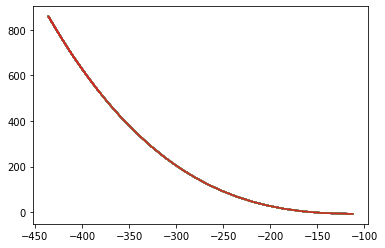

In [3]:
print(np.max(n_ice_ez))
print(np.max(N_ice))
print(np.max(n_snow_ez))
print(np.max(N_snow))

plt.plot(tau[:,0], f_tau[:,0])
#plt.plot(P_dry[:,0],temp[:,0])
#plt.xlabel('Pressure')
#plt.ylabel('Temperature [K]')
# n/V = RT/P

In [5]:
# Next, interpolate so we have evenly spaced altitude layers
# We don't need this anymore


# basically, my charge distribution will be upside down (bottom of the atmosphere will be at the top)
'''
# Interpolation of z, temp, and number density, and delta_q in the pressure/z-direction using regular grid interpolater
# This interpolation is to get evenly spaced 
interp_func = interpolate.RegularGridInterpolator((z_ascending, lat, lon), q_total, method = 'linear', bounds_error = False, fill_value = None) # this creates a function delta_q(z)
z_i = z_ascending[0]
z_f = z_ascending[len(z)-1]
z_even = np.linspace(z_i, z_f, len(z)) # evenly spaced altitude values in our range - new grid

# initialize an array of zeros, which will populate with the interpolated values
rho_q_new = np.zeros(np.shape(temp))

# Now, temperature and number density of each layer

# function to find T(z)
T_fun = interpolate.RegularGridInterpolator((z_ascending, lat, lon), temp, method = 'linear', bounds_error = False, fill_value = None) 
# function to find Nd(z)
Nd_fun = interpolate.RegularGridInterpolator((z_ascending, lat, lon), nd, method = 'linear', bounds_error = False, fill_value = None) 

# Now that I have my interpolation functions, find the interpolated values at each gridpoint
temp_even = np.zeros(np.shape(temp)) # temperature with evenly spaced altitude layers
Nd_even = np.zeros(np.shape(temp)) # number density with evenly spaced altitude layers

# fill in each gridpoint of the new array
for i in range(len(z_even)):
    for j in range(len(lat)):
        for k in range(len(lon)):
            rho_q_new[i,j,k] = interp_func((z_even[i],lat[j],lon[k])) # my interpolated charge separation values
            temp_even[i,j,k] = T_fun((z_even[i], lat[j], lon[k]))
            Nd_even[i,j,k] = Nd_fun((z_even[i],lat[j],lon[k]))
'''

In [5]:
print(z)

[273245.84030885 257167.22543282 241771.08495942 225133.50188597
 211840.79002877 200269.97182194 189578.4462215  181702.29448956
 176434.54395885 168833.25721373 163943.41331864 157480.599824
 153751.27271951 148412.52620456 141945.52628959 136009.83245183
 130181.13862882 123672.52388865 115474.21236    107821.17137736
  99987.9572576   94260.17025252  89086.06803845  82568.50873423
  76708.89665743  69937.70230985  61938.77058647  53130.74821145
  45302.50176423  36005.3768454   25756.52141161  14941.99963548
      0.        ]


In [7]:
###### Zooming in on a single grid column, and using the surrounding layers to interpolate values ######
## Since my altitude range is much smaller than my latitude and longitude ranges, I'm going to use the entire altitude range
# This cell is really slow # 
    
q_max = np.amax(abs(q_total)) # grid cell with the maximum charge separation
print(q_max)
grid_index_z, grid_index_lat, grid_index_lon = np.where(abs(q_total) == np.amax(abs(q_total))) # index where the maximum charge separation occurs
# I don't care about grid_index_z because I'm using all z values

# I need the indices to be integers, not arrays
grid_index_lat = grid_index_lat[0]
grid_index_lon = grid_index_lon[0]
lat_indices = np.array([grid_index_lat -1, grid_index_lat, grid_index_lat+1])
lon_indices = np.array([grid_index_lon -1, grid_index_lon, grid_index_lon+1])

# pick the latitude and longitude values for the interpolation
lat_vals = np.array([lat[grid_index_lat-1], lat[grid_index_lat], lat[grid_index_lat+1]])
lon_vals = np.array([lon[grid_index_lon-1], lon[grid_index_lon], lon[grid_index_lon + 1]])

# to avoid having a corner piece
if grid_index_lat == 0:
    lat_vals[0] = lat[grid_index_lat]-(lat[grid_index_lat+1]-lat[grid_index_lat])
if grid_index_lon == 0:
    lon_vals[0] = lon[grid_index_lon]-(lat[grid_index_lon+1]-lat[grid_index_lon])

print(lat_vals)
print(lon_vals)

# My small charge separation, temperature, and number density arrays
rho_q_smol = np.zeros((len(z),3,3), dtype = float)
t_smol = np.zeros((len(z),3,3), dtype = float)
nd_smol = np.zeros((len(z),3,3), dtype = float)
for k in range(3):
    for j in range (3):
        for i in range (len(z)):
            rho_q_smol[i,j,k] = q_total[i,lat_indices[j], lon_indices[k]]
            t_smol[i,j,k] = temp[i,lat_indices[j], lon_indices[k]]
            nd_smol[i,j,k] = nd[i,lat_indices[j], lon_indices[k]]
            
# the z values must be strictly ascending, so I need to flip q along the z axis
z_ascending = np.flip(z) # regular grid inteprolator requires all the dimensions to be strictly increasing
q_smol_flipped = np.flip(rho_q_smol, axis = 0)
t_smol_flipped = np.flip(t_smol, axis = 0)
nd_smol_flipped = np.flip(nd_smol, axis=0)

# I need 120 grid points in each direction so I can have a final grid size of 40x40
lat_range = np.linspace(lat_vals[0], lat_vals[2], 120)
lon_range = np.linspace(lon_vals[0], lon_vals[2], 120)
#interp_x = np.zeros((len(z_even), len(lat_range), len(lon_range)), dtype = float)



# Interpolation functions
q_interp_function = interpolate.RegularGridInterpolator((z_ascending,lat_vals, lon_vals), q_smol_flipped, method = 'linear', bounds_error = False, fill_value = None)
t_interp_function = interpolate.RegularGridInterpolator((z_ascending, lat_vals, lon_vals), t_smol_flipped, method = 'linear', bounds_error = False, fill_value = None)
nd_interp_function = interpolate.RegularGridInterpolator((z_ascending, lat_vals, lon_vals), nd_smol_flipped, method = 'linear', bounds_error = False, fill_value = None)

# new interpolated arrays
q_interpolated = np.zeros((len(z_ascending),len(lat_range), len(lon_range)), dtype = float)
temp_interpolated = np.zeros(np.shape(q_interpolated))
nd_interpolated = np.zeros(np.shape(q_interpolated))

# evaluate the interpolation
for i in range(len(z)):
    for j in range (len(lat_range)):
        for k in range (len(lon_range)):
            q_interpolated[i,j,k] = q_interp_function((z_ascending[i],lat_range[j],lon_range[k]))
            temp_interpolated[i,j,k] = t_interp_function((z_ascending[i],lat_range[j],lon_range[k]))
            nd_interpolated[i,j,k] = nd_interp_function((z_ascending[i],lat_range[j],lon_range[k]))



3.1317565037335475e-05
[16.32407407 16.56481481 16.80555556]
[6.09375  6.328125 6.5625  ]


In [8]:
print(np.max(q_interpolated))


3.0931765853552904e-05


(33,)


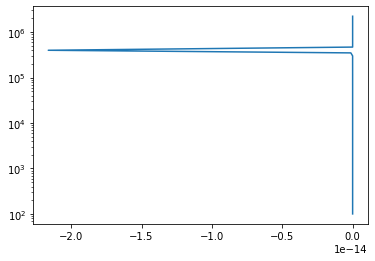

In [10]:
# Now, extract only the original grid cell, over all altitude values which now has now been broken up into 40x40x40
N_lat = 40
N_lon = 40
N_z = len(z_ascending)
q_smoller = q_interpolated[:,39:79,39:79]
temp_final = temp_interpolated[:,39:79,39:79]
nd_final = nd_interpolated[:,39:79,39:79]

# Find the charge density
dz = abs(z_ascending[1]-z_ascending[0]) # length of one gridcell in the z-direction, in meters
dx = abs(lat_range[1]-lat_range[0])*1166820 # length of one grid cell in the latitude direction, in meters (1166.82 km in one degree at 24 N)
dy = abs(lon_range[1]-lon_range[0])*1220000 # length of one grid cell in the longitude direction, in meters (1220.18km = 1 degree longitude)
grid_volume = dz*dx*dy # in m^3

# charge density
rho_q = q_smoller

# we want charge density in nano C/m**3
#rho_q = 10**9*rho_q
#plt.plot(rho_q[:,0],z_even)
plt.clf()
print(q_total[:,0,0].shape)
plt.plot(q_total[:,0,0], P_dry[:,0,0])
plt.yscale('log')

In [8]:
# Writing my data to output files

# Nxyz.dat - number of gridpoints
Nx = N_lat
Ny = N_lon
Nz = N_z
Nxyz = np.array([Nx, Ny, Nz])
#c = open(newpath + '/Nxyz.dat', 'w+')
np.savetxt(newpath + '/Nxyz.dat', Nxyz)
#c.close()

# Dxyz.dat - resolution
Dxyz = np.array([dx, dy, dz])
h = open(newpath + '/Dxyz.dat', 'w+')
np.savetxt(newpath + '/Dxyz.dat', Dxyz)
h.close()

# ground z - the ground altitude
z_ground = np.array([0]) #in meters
zg = open(newpath + '/z_gnd.dat', 'w+')
np.savetxt(newpath + '/z_gnd.dat', z_ground)
zg.close()
'''
rho_q[1,1,1]
# charge density
with open(newpath + "/rhoAmb.dat", 'w') as outfile:
    for data_slice in rho_q:
        outfile.write('# new slice \n')
        np.savetxt(outfile, data_slice)
        
'''
outfile =open(newpath + '/rhoAmb.dat', 'w')
rho_q_nC = rho_q*10**9
for k in range(Nz): # pressure/altitude
    for i in range(Nx): # latitude
        for j in range(Ny): # longitude
        #np.savetxt(outfile,np.transpose(rho_q[k,i,:]))
            outfile.write('%f ' %rho_q_nC[k,i,j])
            #outfile.write('')
            
        outfile.write('\n')
        
    outfile.write('\n')
            
outfile.close()     
'''
#l.write('# Array shape: {0}\n'.format(np.shape(q_density)))
q_density_2d = np.reshape(rho_q, (Nx*(Nz), Ny)) # reshaping q_density so it's a 2d "stack" of all the slices
np.savetxt(newpath + '/rhoAmb.dat', q_density_2d)
'''

#print(q_density_2d)
# average temperature in each vertical layer
o = open(newpath + "/avg_temp.dat", 'w+')
avg_temp = np.zeros((Nz,), dtype = float) # average temperature of each vertical layer
for i in range(Nz):
    avg_temp[i] = np.average(temp_final[i,:,:], axis = None)
o.write('# Array shape: {0}\n'.format(np.shape(avg_temp)))
np.savetxt(newpath + '/avg_temp.dat', avg_temp)
o.close()

# average number density in each vertical layer
e = open(newpath + "/avg_nd.dat", 'w+')
avg_nd = np.zeros((Nz,), dtype = float)
for i in range (Nz):
    avg_nd[i] = np.average(nd_final[i,:,:], axis = None)
e.write('# Array shape: {0}\n'.format(np.shape(avg_nd)))
np.savetxt(newpath + '/avg_nd.dat', avg_nd)
e.close()

# z - altitude (in km)
k = open(newpath + "/alt.dat", 'w+')
k.write('# Array shape: {0}\n'.format(np.shape(z)))
k.write('Altitude (km)')
np.savetxt(newpath + '/alt.dat', z[:])
k.close()




In [9]:
print(avg_nd)

[4.51857620e+19 6.96590554e+19 1.06212358e+20 1.78980072e+20
 4.29198386e+20 8.82259514e+20 1.72440883e+21 3.11135203e+21
 5.00501003e+21 8.19876487e+21 1.39880692e+22 1.99342021e+22
 2.51746874e+22 3.17022581e+22 3.89613353e+22 4.68511627e+22
 5.87879548e+22 7.54767915e+22 9.48636431e+22 1.12974607e+23
 1.32893325e+23 1.51417503e+23 1.74339115e+23 1.93933732e+23
 2.11689696e+23 2.28764718e+23 2.47308012e+23 2.65243471e+23
 2.82828739e+23 3.03185053e+23 3.24809574e+23 3.53871663e+23
 3.83919468e+23]


(81,)
(33, 81, 64)
4.2599044223696057e-07
4.2599044223696057e-07


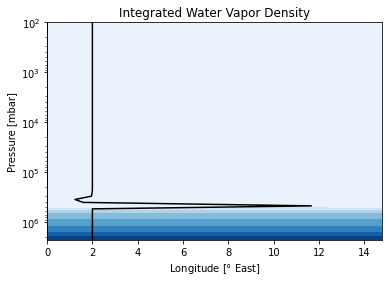

<Figure size 432x288 with 0 Axes>

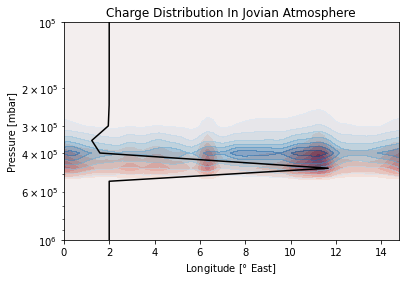

<Figure size 432x288 with 0 Axes>

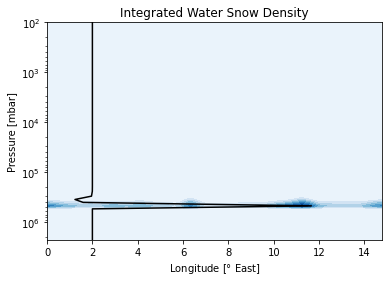

<Figure size 432x288 with 0 Axes>

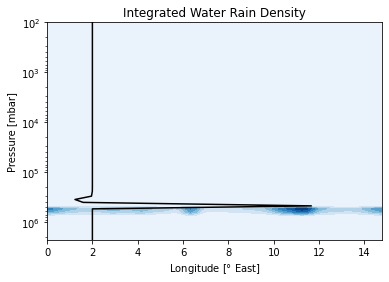

<Figure size 432x288 with 0 Axes>

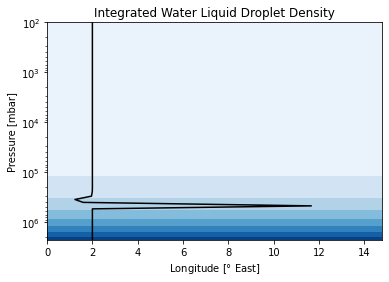

<Figure size 432x288 with 0 Axes>

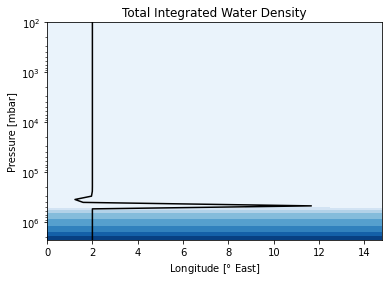

In [12]:
# Making plots
print(lat.shape)
print(P_dry.shape)

# integrate the density of each species over all latitudes (axis 1 = latitude)
integrated_ice_density = np.trapz(CWC_ice, lat, axis = 1)
integrated_snow_density = np.trapz(CWC_snow, lat, axis = 1)
integrated_rain_density = np.trapz(CWC_rain, lat, axis = 1)
integrated_liquid_density = np.trapz(CWC_liquid, lat, axis = 1)
integrated_vapor_density = np.trapz(CWC_vapor, lat, axis = 1)
integrated_everything = np.trapz(CWC_all, lat, axis = 1)

# average q over all latitudes
avg_q = np.mean(q_total, axis = 1)
avg_q_x2 = np.mean(avg_q, axis = 1)*10**8*4+2
print(np.max(avg_q))
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111) ## creates the axis
# plot the contours
# First, vapor
ax.plot(avg_q_x2, P_dry[:,0,0], color = 'k', zorder = 5)
ax.contourf(lon, P_dry[:,0,0], integrated_vapor_density, cmap=plt.get_cmap("Blues"))
ax.set_yscale('log')
ax.invert_yaxis()
ax.plot(avg_q, P_dry[:,0,0], color = 'k', zorder = 5)
ax.set_ylabel('Pressure [mbar]')
ax.set_xlabel(r'Longitude [$\degree$ East]')
plt.title('Integrated Water Vapor Density')

plt.figure()
f, ax1 = plt.subplots()
ax1.plot(avg_q_x2, P_dry[:,0,0], color = 'k')
ax1.contourf(lon, P_dry[:,0,0], integrated_snow_density, cmap=plt.get_cmap("Reds"))
ax1.contourf(lon, P_dry[:,0,0], integrated_ice_density, cmap=plt.get_cmap("Blues"), alpha = 0.5)
ax1.set_ylim(10**5,10**6)
ax1.set_yscale('log')
ax1.invert_yaxis()
ax1.set_ylabel('Pressure [mbar]')
ax1.set_xlabel(r'Longitude [$\degree$ East]')
plt.title('Charge Distribution In Jovian Atmosphere')

plt.figure()
f2, ax2 = plt.subplots()
ax2.plot(avg_q_x2, P_dry[:,0,0], color = 'k')
ax2.contourf(lon, P_dry[:,0,0], integrated_snow_density, cmap=plt.get_cmap("Blues"))
ax2.set_yscale('log')
ax2.invert_yaxis()
ax2.set_ylabel('Pressure [mbar]')
ax2.set_xlabel(r'Longitude [$\degree$ East]')
plt.title('Integrated Water Snow Density')

plt.figure()
f3, ax3 = plt.subplots()
ax3.plot(avg_q_x2, P_dry[:,0,0], color = 'k')
ax3.contourf(lon, P_dry[:,0,0], integrated_rain_density, cmap=plt.get_cmap("Blues"))
ax3.set_yscale('log')
ax3.invert_yaxis()
ax3.set_ylabel('Pressure [mbar]')
ax3.set_xlabel(r'Longitude [$\degree$ East]')
plt.title('Integrated Water Rain Density')

plt.figure()
f4, ax4 = plt.subplots()
ax4.plot(avg_q_x2, P_dry[:,0,0], color = 'k')
ax4.contourf(lon, P_dry[:,0,0], integrated_liquid_density, cmap=plt.get_cmap("Blues"))
ax4.set_yscale('log')
ax4.invert_yaxis()
ax4.set_ylabel('Pressure [mbar]')
ax4.set_xlabel(r'Longitude [$\degree$ East]')
plt.title('Integrated Water Liquid Droplet Density')

plt.figure()
f5, ax5 = plt.subplots()
ax5.plot(avg_q_x2, P_dry[:,0,0], color = 'k')
ax5.contourf(lon, P_dry[:,0,0], integrated_everything, cmap=plt.get_cmap("Blues"))
ax5.set_yscale('log')
ax5.invert_yaxis()
ax5.set_ylabel('Pressure [mbar]')
ax5.set_xlabel(r'Longitude [$\degree$ East]')
plt.title('Total Integrated Water Density')

print(np.max(avg_q))

Text(0.5, 1.0, 'Charge Distribution In Jovian Atmosphere')

<Figure size 432x288 with 0 Axes>

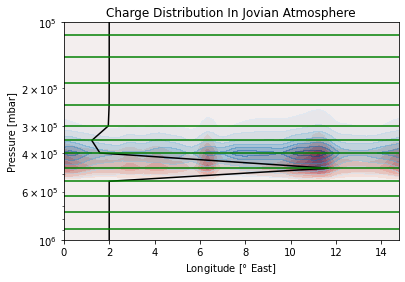

In [13]:
# plot
plt.figure()
f, ax1 = plt.subplots()
ax1.plot(avg_q_x2, P_dry[:,0,0], color = 'k')
ax1.contourf(lon, P_dry[:,0,0], integrated_snow_density, cmap=plt.get_cmap("Reds"))
ax1.contourf(lon, P_dry[:,0,0], integrated_ice_density, cmap=plt.get_cmap("Blues"), alpha = 0.5)
# plot the pressure lines
for i in range(len(P_dry[:,0,0])):
    plt.axhline(P_dry[i,0,0], color = 'green')
ax1.set_ylim(10**5,10**6)
ax1.set_yscale('log')
ax1.invert_yaxis()
ax1.set_ylabel('Pressure [mbar]')
ax1.set_xlabel(r'Longitude [$\degree$ East]')
plt.title('Charge Distribution In Jovian Atmosphere')


3.1317565037335475e-05
-1.0884572845654204e-06


<Figure size 432x288 with 0 Axes>

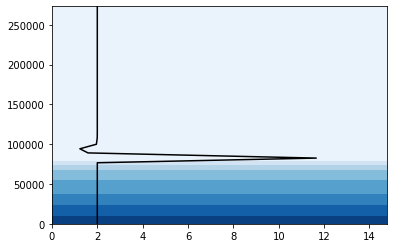

In [19]:
# plotting with respect to z
plt.figure()
f6, ax6 = plt.subplots()
ax6.plot(avg_q_x2, z, color = 'k')
ax6.contourf(lon, z, integrated_everything, cmap = plt.get_cmap("Blues"))
print(np.max(q_total))
print(np.min(q_total))